### Install Libraries (add to requirements.txt)

!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install ultralytics==8.0.196
!pip install fastapi
!pip install "uvicorn[standard]"
!pip install python-multipart

### Import Relevant Libaries

### VENV 

!YOLO_Object_Detection\Scripts\activate

In [3]:
import torch
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import requests
from roboflow import Roboflow
from fastapi import FastAPI, UploadFile

#### Check if CUDA available. If yes, Use it over CPU

In [4]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: None
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 4050 Laptop GPU


## Get Dataset

In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key="mvftf7eVgMNpJA9Z9LVx")
project = rf.workspace("moyed-chowdhury").project("mv_train_dataset_2")
dataset = project.version(1).download("yolov8")


loading Roboflow workspace...
loading Roboflow project...


### Display an example image box segmentation

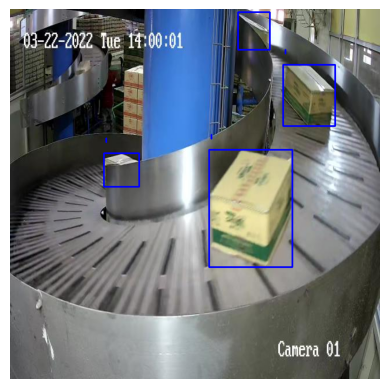

In [6]:
def read_label_file(label_file):
    with open(label_file, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        line = line.strip().split()
        class_id = int(line[0])
        x_center, y_center, width, height = map(float, line[1:])
        # Convert YOLO format to pixel coordinates
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)
        boxes.append((x1, y1, x2, y2, class_id))
    return boxes

def draw_boxes(image, boxes,labels):
    for box in boxes:
        x1, y1, x2, y2, class_id = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        label = labels[class_id]
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    return image

# Load image
image_path = r"MV_Train_Dataset_2-1\train\images\Energy-00041_jpg.rf.1e096db3f817c82bb14796c45addeb20.jpg"
image = cv2.imread(image_path)
img_height, img_width, _ = image.shape

# Read label file
label_file = r"MV_Train_Dataset_2-1\train\labels\Energy-00041_jpg.rf.1e096db3f817c82bb14796c45addeb20.txt"
boxes = read_label_file(label_file)

# Define class names (assuming class IDs are indices)
class_names =  ["'", "biotite", "bornite", "chrysocolla", "malachite", "muscovite", "pyrite", "quartz"]

# Draw bounding boxes with labels
image_with_boxes = draw_boxes(image.copy(), boxes, class_names)

# Display image with bounding boxes
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## Object Detection Modelling (ML)

### Yolo8

#### Train

In [7]:
# Load the model.
model = YOLO('yolov8n.pt')
 
# Training.
results = model.train(
   data=r'C:\Users\abhij\Documents\CV_Object_Detection\YOLO_Object_Detection\Box_Detection\MV_Train_Dataset_2-1\data.yaml',
   imgsz=640,
   epochs=5,
   batch=10,
   name='Box_Detection')

New https://pypi.org/project/ultralytics/8.1.10 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196  Python-3.11.8 torch-2.2.0+cpu CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6141MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Users\abhij\Documents\CV_Object_Detection\YOLO_Object_Detection\Box_Detection\MV_Train_Dataset_2-1\data.yaml, epochs=5, patience=50, batch=10, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=Box_Detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_lab

#### Validation

In [10]:
# Load a model
best_model_source = r'C:\Users\abhij\Documents\CV_Object_Detection\YOLO_Object_Detection\Box_Detection\runs\detect\Box_Detection\weights\best.pt'
model = YOLO(best_model_source)  # pretrained YOLOv8n model

In [11]:
# Validate the model
metrics = model.val(name='Box_Detection_Val')  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.0.196  Python-3.11.8 torch-2.2.0+cpu CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6141MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning C:\Users\abhij\Documents\CV_Object_Detection\YOLO_Object_Detection\Box_Detection\MV_Train_Dataset_2-1\valid\labels.cache... 294 images, 19 backgrounds, 0 corrupt: 100%|██████████| 294/294 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]
                   all        294        737      0.969      0.969      0.991      0.912
        Energy_Regular        294        553      0.991      0.959      0.992      0.917
         Energy_Tiffin        294        184      0.947      0.978      0.989      0.907
Speed: 0.5ms preprocess, 7.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs\detect\Box_Detection_Val


array([    0.91686,     0.90705])

#### Testing


0: 640x640 3 Energy_Regulars, 26.9ms
Speed: 2.9ms preprocess, 26.9ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


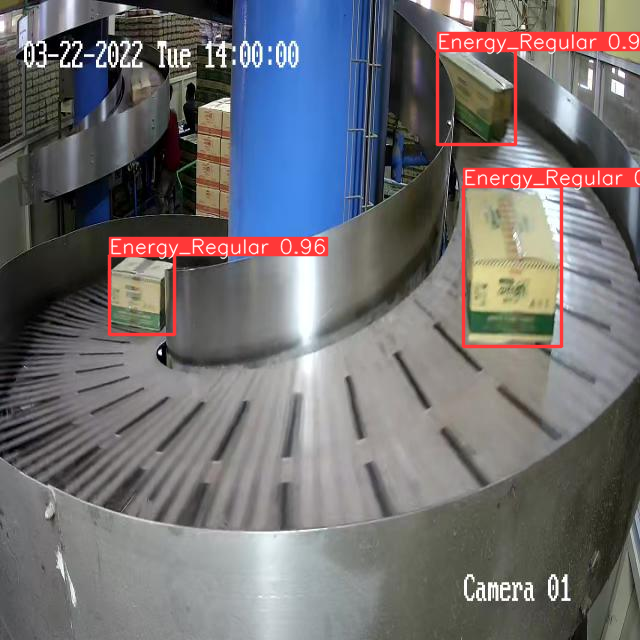

In [15]:
# Load an image
source = r'C:\Users\abhij\Documents\CV_Object_Detection\YOLO_Object_Detection\Box_Detection\MV_Train_Dataset_2-1\test\images\Energy-00021_jpg.rf.d10e2f9864e673fd97bfcfc200dd56de.jpg'

# Run batched inference on a list of images
results = model([source])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs

# Show the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    #im.show()  # show image
    im.save('results.jpg')  # save image
    
im

In [16]:
## Results on entire test dataset

metrics = model.val(name='Box_Detection_Test',split='test')  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.0.196  Python-3.11.8 torch-2.2.0+cpu CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6141MiB)
val: Scanning C:\Users\abhij\Documents\CV_Object_Detection\YOLO_Object_Detection\Box_Detection\MV_Train_Dataset_2-1\test\labels... 153 images, 9 backgrounds, 0 corrupt: 100%|██████████| 153/153 [00:00<00:00, 2197.08it/s]
val: New cache created: C:\Users\abhij\Documents\CV_Object_Detection\YOLO_Object_Detection\Box_Detection\MV_Train_Dataset_2-1\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]
                   all        153        382      0.992      0.949      0.993      0.913
        Energy_Regular        153        292      0.996      0.962      0.994      0.923
         Energy_Tiffin        153         90      0.988      0.935      0.993      0.904
Speed: 0.9ms preprocess, 14.8ms inference, 0.0ms loss, 8.2ms postprocess per image
Results saved to runs\detect\Box_Detec

array([    0.92263,     0.90375])